In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from testCases_v2 import *
from planar_utils import load_planar_dataset,plot_decision_boundary,load_extra_datasets,sigmoid
np.random.seed(1)
%matplotlib inline

In [2]:
X,Y=load_planar_dataset()
X_orig=X

In [3]:
shape_x=X.shape
shape_y=Y.shape
m=Y.shape[1]
print(shape_x)
print(shape_y)

(2, 400)
(1, 400)


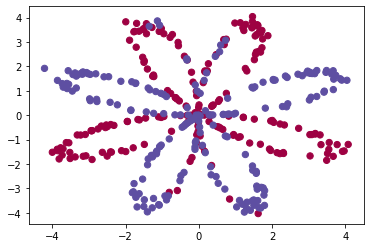

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
clf=sklearn.linear_model.LogisticRegressionCV()

In [6]:
clf.fit(X.T,Y.T)

/home/prudhvi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

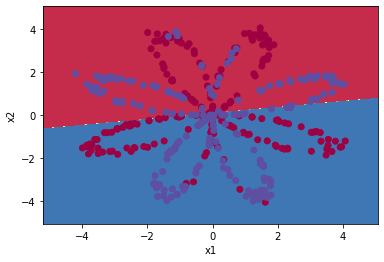

In [7]:
plot_decision_boundary(lambda x: clf.predict(x),X,Y)

In [8]:
lr_predictions=clf.predict(X.T)

In [9]:
print(f"accuracy={(np.dot(Y,lr_predictions)+np.dot(1-Y,1-lr_predictions))/m}")

accuracy=[0.47]


## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

#### CC:-Coursera

In [10]:
def layer_sizes(X,y):
    n_x=X.shape[0]
    n_h=4
    n_y=y.shape[0]
    return n_x,n_h,n_y

In [11]:
X_a,Y_a=layer_sizes_test_case()
print(layer_sizes(X_a,Y_a))

(5, 4, 2)


In [12]:
def initialize_parameters(n_x,n_h,n_y):
    np.random.seed(2)
    W1=np.random.randn(n_h,n_x)*0.01
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h)*0.01
    b2=np.zeros((n_y,1))
    parameters={"W1":W1,"b1":b1,"W2":W2,"b2":b2}
    return parameters

In [13]:
n_x,n_h,n_y=initialize_parameters_test_case()
params=initialize_parameters(n_x,n_h,n_y)
print(params)

{'W1': array([[-0.00416758, -0.00056267],
       [-0.02136196,  0.01640271],
       [-0.01793436, -0.00841747],
       [ 0.00502881, -0.01245288]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]), 'b2': array([[0.]])}


In [14]:
def forward_propagation(X,parameters):
    W1=parameters["W1"]
    W2=parameters['W2']
    b1=parameters["b1"]
    b2=parameters["b2"]
    Z1=W1@X+b1
    A1=np.tanh(Z1)
    Z2=W2@A1+b2
    A2=sigmoid(Z2)
    
    cache={"Z1":Z1,"A1":A1,"Z2":Z2,"A2":A2}
    return A2,cache
    

In [15]:
X_t,parameters=forward_propagation_test_case()
A2,cache=forward_propagation(X_t,parameters)
print(np.mean(cache["Z1"]),np.mean(cache["Z2"]),np.mean(cache["A1"]),np.mean(cache["A2"]))

0.26281864019752443 -1.3076660128732143 0.09199904522700113 0.21287768171914198


In [16]:
def compute_cost(A2,Y,parameters):
    m=Y.shape[1]
    cost=(np.dot(Y,np.log(A2.T))+np.dot(1-Y,np.log(1-A2.T)))*-1/m
    cost=np.squeeze(cost)
    return cost

In [17]:
A2,Y_t,parameters=compute_cost_test_case()
print(compute_cost(A2,Y_t,parameters))

0.6930587610394646


In [18]:
def backward_propagation(parameters,cache,X,y):
    m=Y.shape[1]
    W1=parameters["W1"]
    W2=parameters["W2"]
    b1=parameters["b1"]
    b2=parameters["b2"]
    A1=cache["A1"]
    A2=cache["A2"]
    Z1=cache["Z1"]
    Z2=cache["Z2"]
    dZ2=A2-y
    dW2=dZ2@A1.T/m
    db2=np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1=(W2.T@dZ2)*(1-(np.tanh(Z1)**2))
    
    dW1=dZ1@X.T/m

    db1=np.sum(dZ1,axis=1,keepdims=True)/m
    grads={"dW1":dW1,"db2":db2,"dW2":dW2,"db1":db1}
    return grads
            

In [19]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 2.25767281e-05 -5.60449944e-05]
 [ 1.93475869e-05 -4.80966347e-05]
 [-1.17668928e-05  2.91975152e-05]
 [-4.89027516e-05  1.21368220e-04]]
db1 = [[ 1.32151000e-05]
 [ 1.13246100e-05]
 [-6.88022542e-06]
 [-2.86066341e-05]]
dW2 = [[ 5.91304524e-06  1.32407181e-04 -6.31243370e-06 -7.66895273e-05]]
db2 = [[-0.00124918]]


In [20]:
def update_parameters(parameters,grads,learning_rate=1.2):
    W1=parameters["W1"]
    W2=parameters["W2"]
    b1=parameters["b1"]
    b2=parameters["b2"]
    dW1=grads["dW1"]
    dW2=grads["dW2"]
    db1=grads["db1"]
    db2=grads["db2"]
    W1 -= learning_rate*dW1
    W2 -= learning_rate*dW2
    b1 -= learning_rate*db1
    b2 -= learning_rate*db2
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters
    

In [21]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [22]:
def nn_model(X,Y,n_h,num_iterations,print_cost=True):
    np.random.seed(3)
    n_x,_,n_y=layer_sizes(X,Y)
    parameters=initialize_parameters(n_x,n_h,n_y)
    
    for i in range(num_iterations):
        A2,cache=forward_propagation(X,parameters)
        
        cost=compute_cost(A2,Y,parameters)
        
        grads=backward_propagation(parameters,cache,X,Y)
        
        parameters=update_parameters(parameters,grads)
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return parameters    

In [23]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.127519
Cost after iteration 2000: 0.030788
Cost after iteration 3000: 0.016174
Cost after iteration 4000: 0.010772
Cost after iteration 5000: 0.008018
Cost after iteration 6000: 0.006363
Cost after iteration 7000: 0.005263
Cost after iteration 8000: 0.004482
Cost after iteration 9000: 0.003899
W1 = [[-0.45278056  0.853977  ]
 [-0.58803774  1.08579135]
 [ 0.34231249 -0.6895003 ]
 [ 0.59495677 -1.11170444]]
b1 = [[ 0.16282352]
 [ 0.23498417]
 [-0.11354069]
 [-0.24221992]]
W2 = [[-1.30318784 -1.95970505  0.93869802  2.0367784 ]]
b2 = [[0.22035834]]


In [24]:
def predict(parameters,X):
    A2,cache=forward_propagation(X,parameters)
    
    y_out=A2>0.5
    
    return y_out

In [25]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219472
Cost after iteration 9000: 0.218562


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

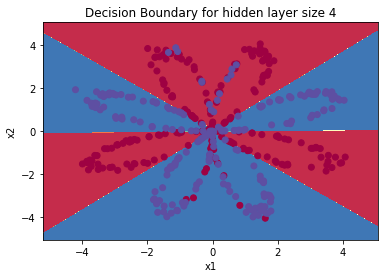

In [26]:

parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [27]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%
